In [3]:
import sys
import numpy as np
import pandas as pd
# import pyqtgraph as pg
import cnmodel as cnm
from cnmodel import populations
from cnmodel.protocols import IVCurve
from neuron import h
import matplotlib.pyplot as plt

In [36]:
temp = np.linspace(-0.3,0.4,11)
temp[1]-temp[0], temp

(np.float64(0.07),
 array([-0.3 , -0.23, -0.16, -0.09, -0.02,  0.05,  0.12,  0.19,  0.26,
         0.33,  0.4 ]))

In [38]:
np.arange(-0.3, 0.45, 0.07)

array([-0.3 , -0.23, -0.16, -0.09, -0.02,  0.05,  0.12,  0.19,  0.26,
        0.33,  0.4 ])

## IC


  [soma] find_i0  Species: guineapig  cell type: I-c  Temp   22.0
    *** found V0 = -63.928681
    *** and cell has mechanisms:  ['kht', 'ka', 'ihvcn', 'leak', 'nacn']


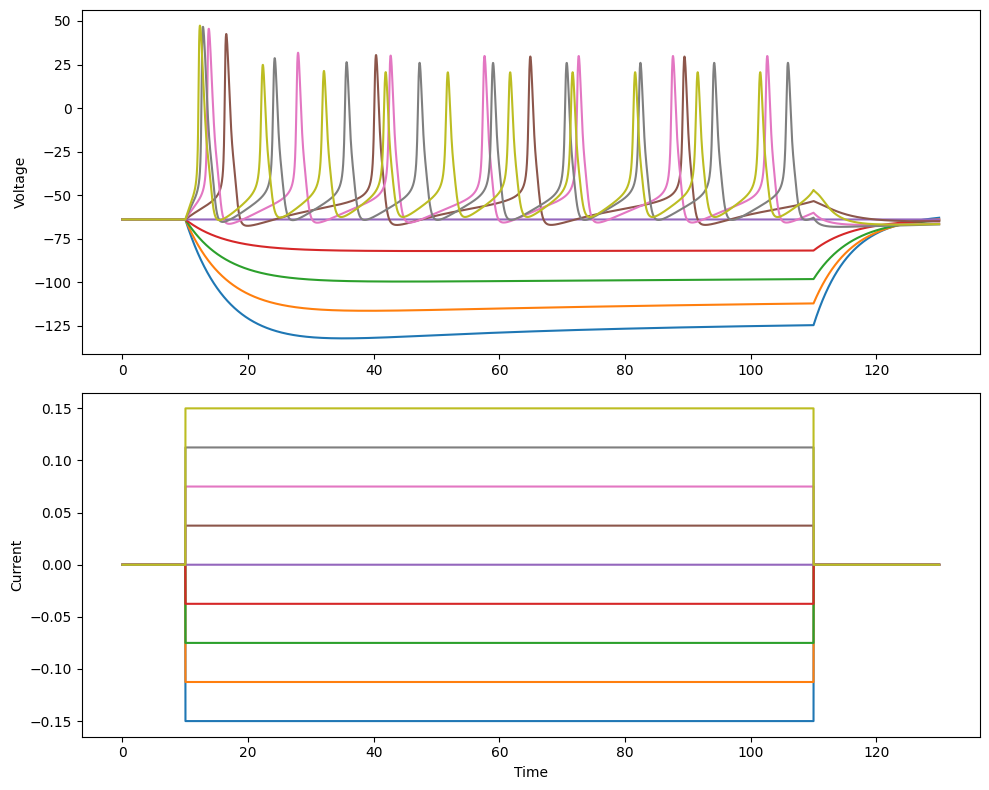

In [34]:
ic_cell = cnm.cells.TStellate.create(modelType='I-c') #,species='mouse')
v0 = ic_cell.find_i0(showinfo=True)
ic_cell.set_temperature(float(34))
iv = IVCurve()
iv.reset()
iv.run({'pulse': [(-0.15, 0.16, 0.0375)]},
       ic_cell, durs=[10, 100, 20],
       sites=None, reppulse=None, temp=float(34))

fig, axs = plt.subplots(2,1, figsize=(10,8))
axs.ravel()

for i, voltage_trace in enumerate(iv.voltage_traces):

    axs[0].plot(iv.time_values, voltage_trace)
    axs[1].plot(iv.time_values, iv.current_traces[i])

# plt.plot(iv.voltage_traces[0], iv.current_traces[0])
# axs[0].set_xlim([350,950])
# axs[1].set_xlim([350,950])
axs[0].set_ylabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_xlabel('Time')

fig.tight_layout()

## Pyramidal


  [soma] find_i0  Species: rat  cell type: pyramidal  Temp   32.0
    *** found V0 = -62.496552
    *** and cell has mechanisms:  ['napyr', 'kdpyr', 'kif', 'kis', 'ihpyr', 'leak']


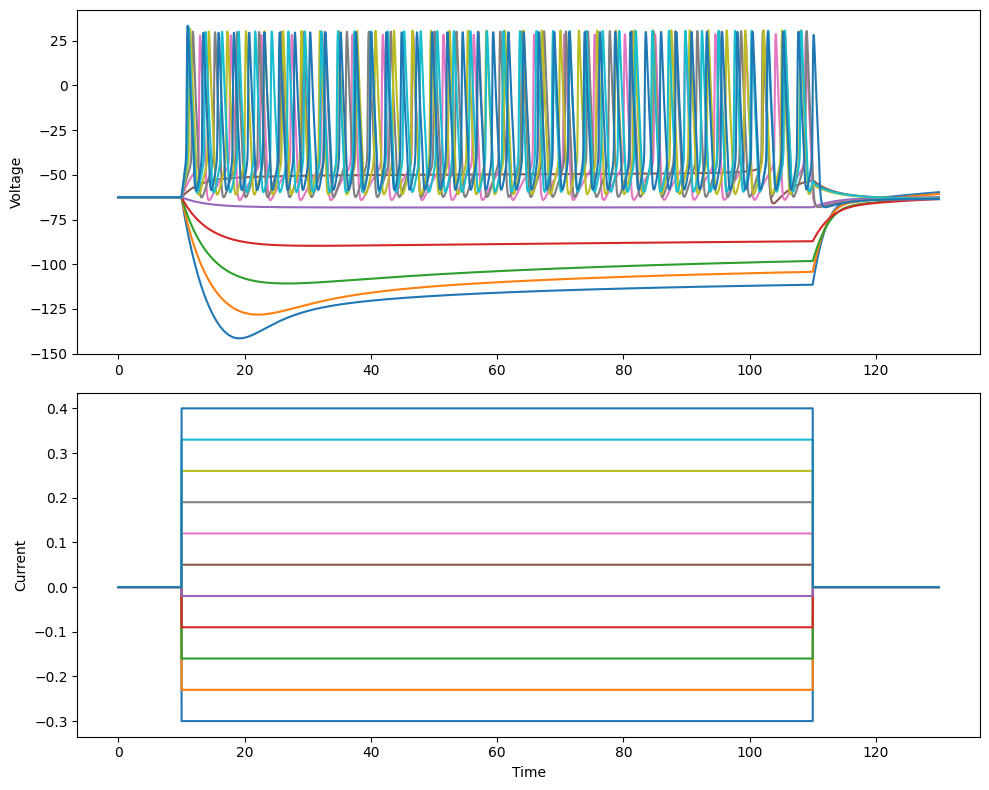

In [39]:
pyramidal_cell = cnm.cells.Pyramidal.create() #,species='mouse')
v0 = pyramidal_cell.find_i0(showinfo=True)
pyramidal_cell.set_temperature(float(34))
iv = IVCurve()
iv.reset()
iv.run({'pulse': [(-0.3, 0.45, 0.07)]},
       pyramidal_cell, durs=[10, 100, 20],
       sites=None, reppulse=None, temp=float(34))

fig, axs = plt.subplots(2,1, figsize=(10,8))
axs.ravel()

for i, voltage_trace in enumerate(iv.voltage_traces):

    axs[0].plot(iv.time_values, voltage_trace)
    axs[1].plot(iv.time_values, iv.current_traces[i])

# plt.plot(iv.voltage_traces[0], iv.current_traces[0])
# axs[0].set_xlim([350,950])
# axs[1].set_xlim([350,950])
axs[0].set_ylabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_xlabel('Time')

fig.tight_layout()

## NS -> IC -> Pyr

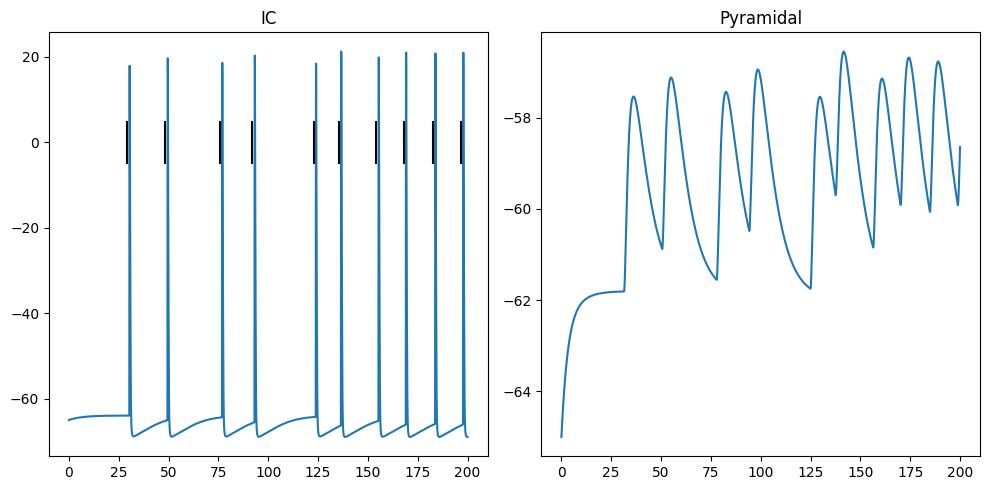

In [41]:
# cf = 16e3
# pyramidal_id = pyramidal.select(1, cf=cf, create=True)
# pyramidal_cell = pyramidal.get_cell(pyramidal_id)[0]

ic_cell = cnm.cells.TStellate.create(modelType='I-c')
pyramidal_cell = cnm.cells.Pyramidal.create()

ic_v = h.Vector().record(ic_cell.soma(0.5)._ref_v)
pyramidal_v = h.Vector().record(pyramidal_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

ns = h.NetStim()
ns.interval = 1000/40  # 80 Hz
ns.number = 2e9
ns.start = 20
ns.noise = 0.5
ns.seed(74)

stim_t = h.Vector()
stim_id = h.Vector()
e_syn = h.ExpSyn(ic_cell.soma(0.5))
nc = h.NetCon(ns, e_syn)
nc.weight[0] = 1
nc.record(stim_t, stim_id)

e_syn_pyr = h.Exp2Syn(pyramidal_cell.soma(0.5))
e_syn_pyr.tau1 = 0.5464  # 0.1 default   # 10
e_syn_pyr.tau2 = 6
# e_syn_pyr.tau2 = 2

nc_pyr = h.NetCon(ic_cell.soma(0.5)._ref_v, e_syn_pyr, sec=ic_cell.soma)
nc_pyr.weight[0] = 0.0005


stim_t_pyr = h.Vector()
stim_id_pyr = h.Vector()
nc_pyr.record(stim_t_pyr, stim_id_pyr)

h.tstop = 0.2*1000
h.dt = 0.025
h.celsius = 34.0

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,2,figsize=(10,5))  #, sharey=True)
axs.ravel()

axs[0].plot(t, ic_v)
axs[0].set_title('IC')
axs[0].vlines(list(stim_t), ymin=-5, ymax=5, color='k')

axs[1].plot(t, pyramidal_v)
# axs[i,1].vlines(list(stim_t_pyr), ymin=-25, ymax=-15, color='k')
axs[1].set_title(f'Pyramidal')

fig.tight_layout()

## NS -> Pyr -> IC

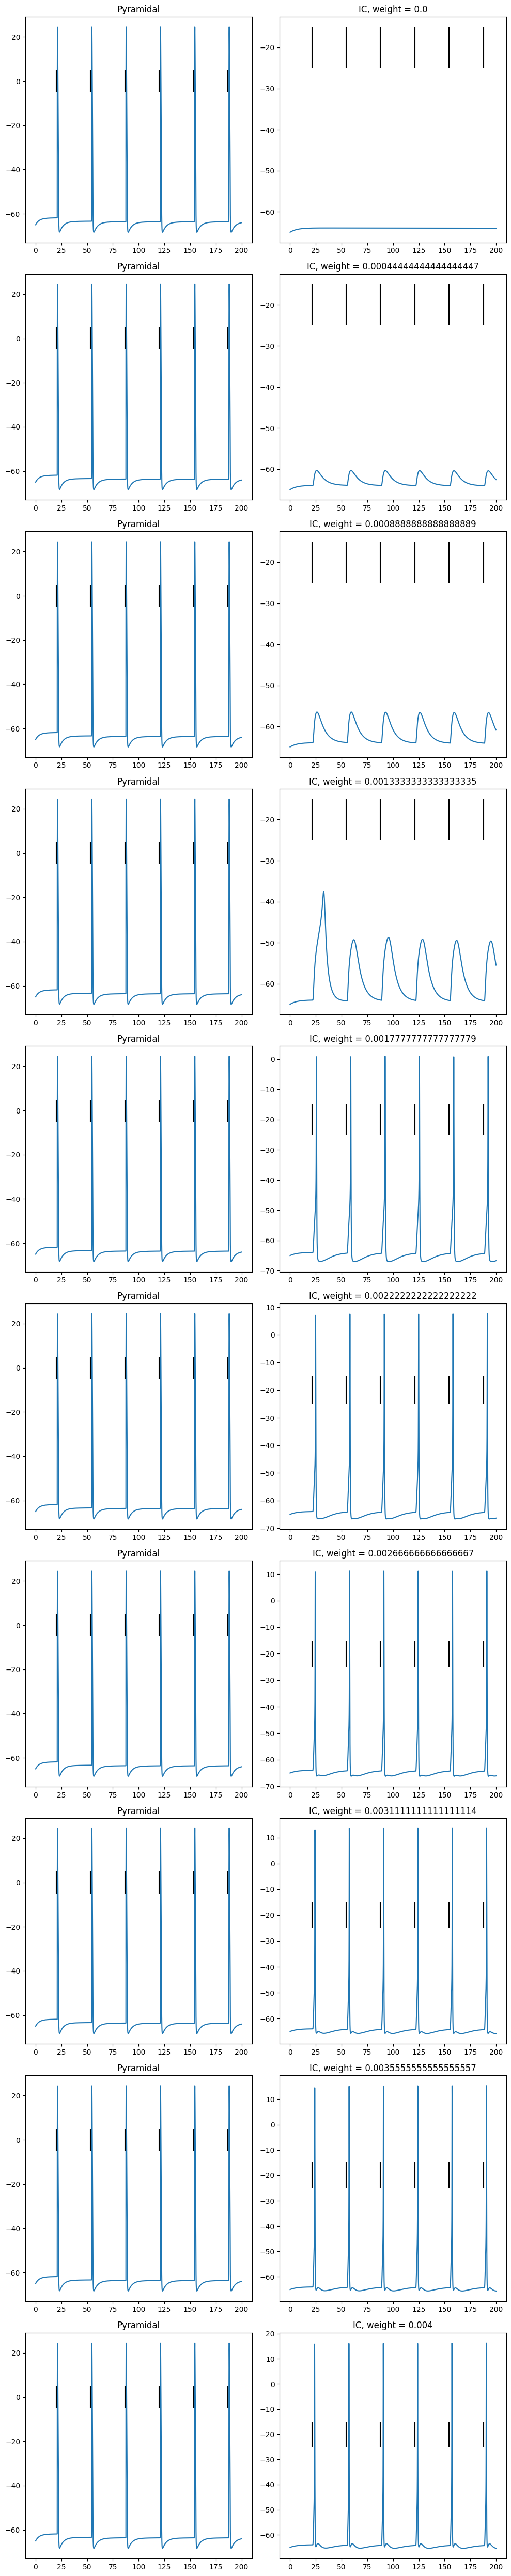

In [59]:
# cf = 16e3
# pyramidal_id = pyramidal.select(1, cf=cf, create=True)
# pyramidal_cell = pyramidal.get_cell(pyramidal_id)[0]

ic_cell = cnm.cells.TStellate.create(modelType='I-c')
pyramidal_cell = cnm.cells.Pyramidal.create()

ic_v = h.Vector().record(ic_cell.soma(0.5)._ref_v)
pyramidal_v = h.Vector().record(pyramidal_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

ns = h.NetStim()
ns.interval = 1000/30  # 80 Hz
ns.number = 2e9
ns.start = 20
ns.noise = 0
ns.seed(74)

stim_t = h.Vector()
stim_id = h.Vector()
e_syn = h.ExpSyn(pyramidal_cell.soma(0.5))
nc = h.NetCon(ns, e_syn)
nc.weight[0] = 1
nc.record(stim_t, stim_id)

e_syn_ic = h.Exp2Syn(ic_cell.soma(0.5))
e_syn_ic.tau1 = 0.5464  # 0.1 default   # 10
e_syn_ic.tau2 = 1.5

nc_ic = h.NetCon(pyramidal_cell.soma(0.5)._ref_v, e_syn_ic, sec=pyramidal_cell.soma)


weights = np.linspace(0,0.004,10)
# tau2s = np.linspace(1,2,7)

fig, axs = plt.subplots(len(weights),2,figsize=(10,len(weights)*5))  #, sharey=True)
    # axs.ravel()


for i, weight in enumerate(weights):

    if len(weights) > 1:
        ax_l = axs[i,0]
        ax_r = axs[i,1]
    else:
        ax_l = axs[0]
        ax_r = axs[1]
    
    nc_ic.weight[0] = weight  # 0.0015 causes spiking

    stim_t_ic = h.Vector()
    stim_id_ic = h.Vector()
    nc_ic.record(stim_t_ic, stim_id_ic)

    h.tstop = 0.2*1000
    h.dt = 0.025
    h.celsius = 34.0

    cnm.util.custom_init()
    h.run()

    ax_l.plot(t, pyramidal_v)
    ax_l.set_title(f'Pyramidal')
    ax_l.vlines(list(stim_t), ymin=-5, ymax=5, color='k')

    ax_r.plot(t, ic_v)
    ax_r.vlines(list(stim_t_ic), ymin=-25, ymax=-15, color='k')
    ax_r.set_title(f'IC, weight = {weight}')

fig.tight_layout()